# Step-by-step MNIST Digits Classification - Fully Connected Neural Networks

1. Load dataset, explore it (display images, mean, min, max values, etc.) and split it into train, validation and test sets
2. Data scaling
3. One hot encoding
4. Define your model, cost function, optimizer, learning rate
5. Define your callbacks (save your model, patience, etc.)
6. Train your model
    
    6.1 If you are satisfied with the train and validation performance go to the next step
    
    6.2 If you are not satisfied with the train and validation performance go back to step 5
7. Test your model on the test and extract relevant metrics

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

## Load dataset, explore it  and split it into train, validation and test sets

- [Load MNIST Keras](https://keras.io/api/datasets/mnist/#load_data-function)

In [2]:
# Loading the data using the Keras function
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.mnist.load_data() # The data comes already split 
                                                                        # in dev and test sets
print("Development set")
print("Images: ",X_dev.shape)
print("Labels shape:",Y_dev.shape)
print("\nNumber of classes:",np.unique(Y_dev).size)
print("\nClasses:",np.unique(Y_dev))
print("\nTest set")
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)

Development set
Images:  (60000, 28, 28)
Labels shape: (60000,)

Number of classes: 10

Classes: [0 1 2 3 4 5 6 7 8 9]

Test set
Images:  (10000, 28, 28)
Labels shape:  (10000,)


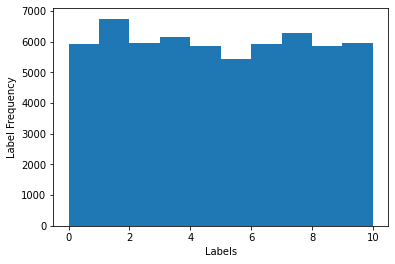

In [3]:
plt.figure()
plt.hist(Y_dev, bins = range(11))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

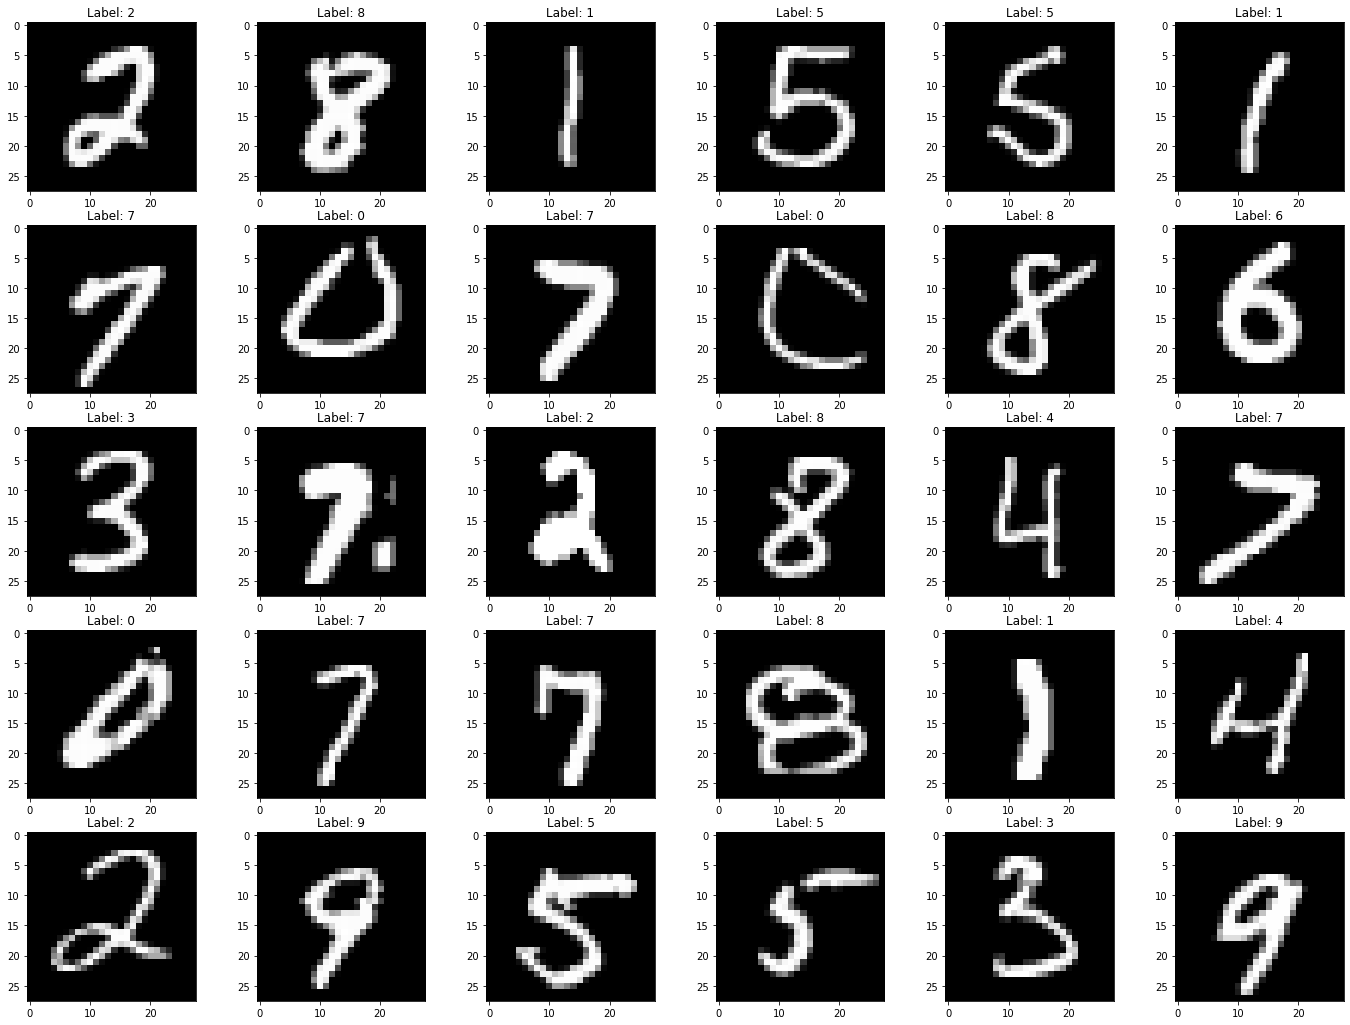

In [4]:
# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(X_dev.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_dev[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()

In [5]:
#The number of classes across samples looks balanced
# Let's shuffle the samples and split them
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit = int(0.75*X_dev.shape[0]) # Train/validation split

# Train and validation split
X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]
X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (45000, 28, 28)
Labels shape:  (45000,)

Validation set
Images:  (15000, 28, 28)
Labels shape:  (15000,)


In [6]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0 255 33.271198951247165 78.51137072290761
0 255 33.46008894557823 78.73543783597944


## 2. Data Scaling 

In [7]:
norm_type = 0 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

## 3. One hot encoding

In [8]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])

Labels:
[0 1 7 1 1]

One hot encoded labels:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


## 4. Define your model, cost function, optimizer, learning rate

In [9]:
def my_model(ishape = (28,28),k = 10, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)
    model_input_flatten = tf.keras.layers.Flatten()(model_input)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(model_input_flatten)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [10]:
model = my_model()
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None


## 5. Define your callbacks (save your model, patience, etc.)

- [Keras callbacks](https://keras.io/api/callbacks/)

In [11]:
model_name = "best_model_mnist.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 6. Train your model

In [12]:
model.fit(X_train,Y_train_oh,batch_size = 32, epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

Epoch 1/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 1.5657 - accuracy: 0.6095 - val_loss: 1.1049 - val_accuracy: 0.7925 - lr: 5.0000e-05
Epoch 2/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.9003 - accuracy: 0.8191 - val_loss: 0.7615 - val_accuracy: 0.8364 - lr: 5.0000e-05
Epoch 3/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.6725 - accuracy: 0.8509 - val_loss: 0.6126 - val_accuracy: 0.8571 - lr: 5.0000e-05
Epoch 4/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.5620 - accuracy: 0.8663 - val_loss: 0.5308 - val_accuracy: 0.8695 - lr: 5.0000e-05
Epoch 5/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.4977 - accuracy: 0.8760 - val_loss: 0.4807 - val_accuracy: 0.8790 - lr: 5.0000e-05
Epoch 6/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.4562 - accuracy: 0.8829 - val_loss: 0.4468 - val_accuracy: 0.8849 - lr: 5.0000e-05
Epoch 7/1000
1407/1407

1407/1407 [==============================] - 2s 1ms/step - loss: 0.3175 - accuracy: 0.9127 - val_loss: 0.3310 - val_accuracy: 0.9083 - lr: 1.5625e-06
Epoch 52/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.3174 - accuracy: 0.9127 - val_loss: 0.3309 - val_accuracy: 0.9084 - lr: 1.5625e-06
Epoch 53/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.3173 - accuracy: 0.9128 - val_loss: 0.3308 - val_accuracy: 0.9085 - lr: 1.5625e-06
Epoch 54/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.3172 - accuracy: 0.9127 - val_loss: 0.3307 - val_accuracy: 0.9085 - lr: 1.5625e-06
Epoch 55/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.3171 - accuracy: 0.9127 - val_loss: 0.3306 - val_accuracy: 0.9085 - lr: 1.5625e-06
Epoch 56/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.3170 - accuracy: 0.9128 - val_loss: 0.3305 - val_accuracy: 0.9085 - lr: 1.5625e-06
Epoch 57/1000
1407/1407 [=====

KeyboardInterrupt: 

## 7. Test your model on the test and extract relevant metrics

In [13]:
model.load_weights(model_name)
metrics = model.evaluate(X_test,Y_test_oh)
print("Categorical cross-entropy:", metrics[0])
print("Accuracy:", metrics[1])

313/313 [==============================] - 0s 901us/step - loss: 0.3078 - accuracy: 0.9167
Categorical cross-entropy: 0.3078319728374481
Accuracy: 0.916700005531311


833


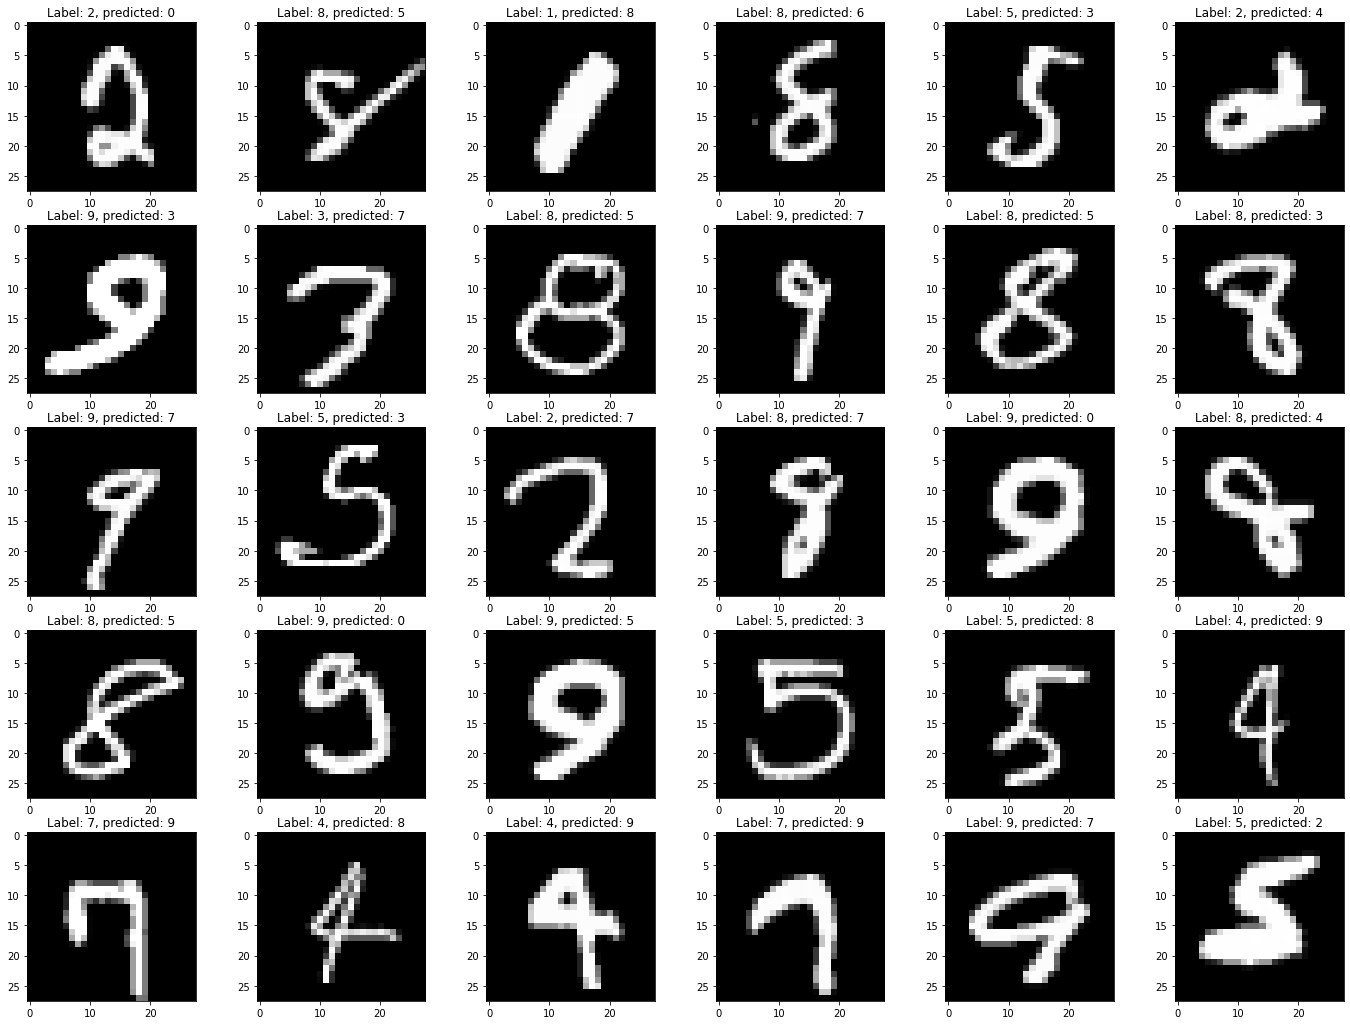

In [14]:
Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## (Optional) Displaying the weights of the layers as images

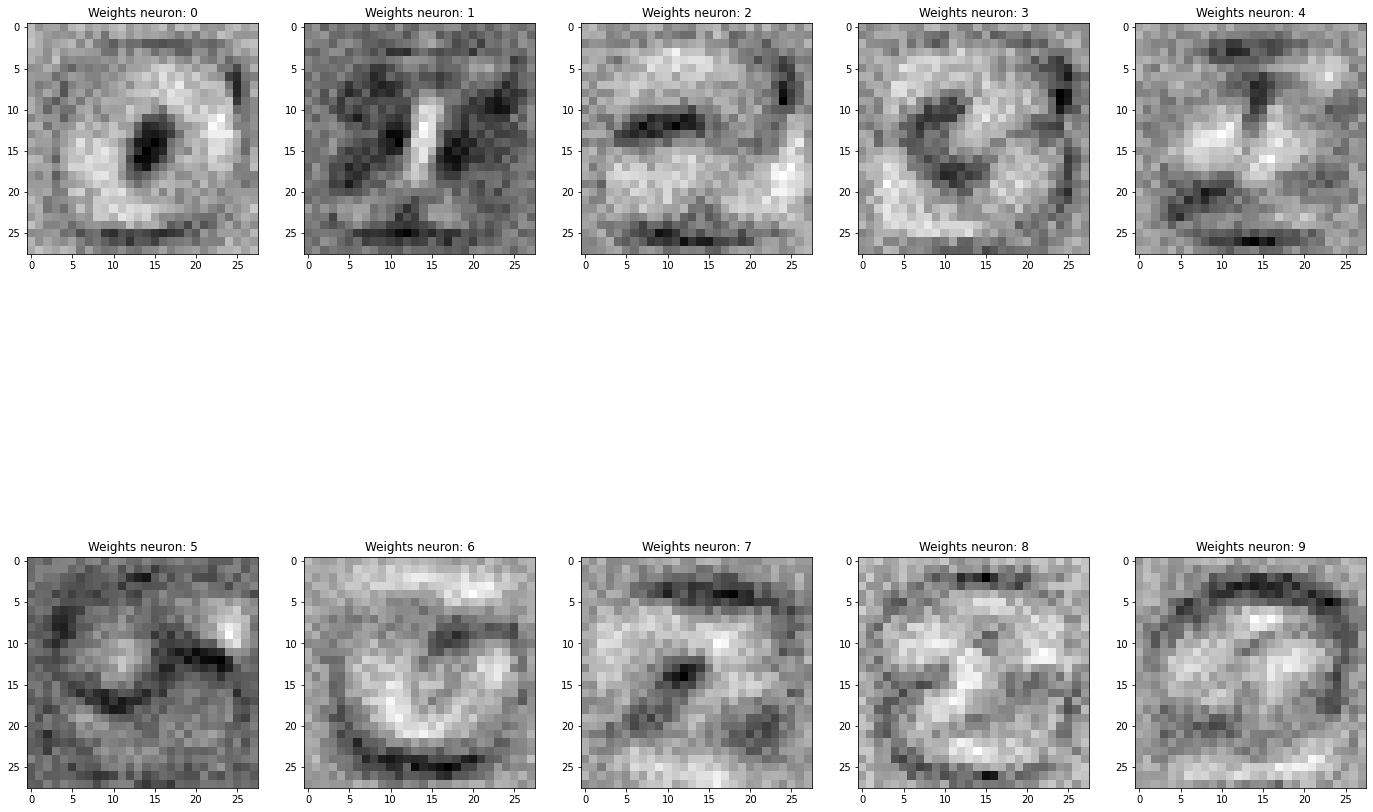

In [15]:
weights = model.get_weights()
plt.figure(figsize = (24,18))
for ii in range(10):
    plt.subplot(2,5,ii+1)
    plt.imshow(weights[0][:,ii].reshape(28,28), cmap = "gray")
    plt.title("Weights neuron: %d" %(ii))
plt.show()